In [433]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.SIM928_voltage_source import SIM # as DC
from nanodrivers.visa_drivers.vna import VNA

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftshift, ifftshift


#file_store
import os

#time
import time
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap

# loaded_table = np.load(file_name, allow_pickle=True).item() # to load as a dictionary

from ctypes import *
%matplotlib inline

Global_data_adress = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA"
exp_name = 'TWPA_noise_4'
adress = Global_data_adress+'\\'+exp_name
if not os.path.exists(adress):
  os.mkdir(adress)
  print("Folder %s created!" % adress)
else:
  print("Folder %s already exists" % adress)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_4 already exists


In [2]:
path = adress +'\\'+ 'gain_database'
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_4\gain_database already exists


In [3]:
dc = SIM()
dc.idn()

Unable to connect device.
 VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
Check that device is connected, visible in NI MAX and is not used by another software.
Connection exist: Stanford_Research_Systems,SIM928,s/n035460,ver2.7



In [441]:
dc.set_volt(0)

In [4]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



In [5]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,1.0.7



In [440]:
anapico.set_off(1)

# Fast gain sweep

The idea is to perorm the following: 
1) Wery rougf sweep of gain to drop half of the subspace, where we don't see any gain

2) Clarify the points above desired gain. It will be the regions of interest. 

3) Perform a more carefull sweep to ensertain the maximum gain point

4) Measure 1\f noise for some of the points



5*) We have noticed, that for dc bias above 5 V MXC is heated up by about 0.5 mK, Still - by 0.5 mK, 4K - by 2 mK 
=> does it increase the noise level? 

The measurements were performed from -7 to 7 V without the capasitor on 16.01.25

In [429]:
# GLOBAL

Max_pump_power = 10
Min_pump_power = 0
Steps_pump_power = 251

Max_pump_freq = 12.5e9
Min_pump_freq = 9e9
Steps_pump_freq = 1001

Max_dc = 4
Min_dc = 0
Steps_dc = 201

def create_non_linear_distribution(min_value, max_value, n_points):
    power_lin = 1.7
    
    if np.mod(n_points, 2) == 0:  
        n_points = 1+n_points//2
        indices = np.append((np.linspace(0, 1, n_points-1, endpoint = True)**power_lin)[1:],-np.linspace(0,1,n_points, endpoint = True)**power_lin)
    else: 
        n_points = 1+n_points//2
        indices = np.append((np.linspace(0, 1, n_points, endpoint = True)**power_lin)[1:],-np.linspace(0,1,n_points, endpoint = True)**power_lin)

    non_linear_values = (max_value + min_value)/2 + (max_value - min_value) * indices/2
    
    return np.sort(non_linear_values)

def setup_VNA():
    vna.set_cw()
    vna.set_cw_freq(5e9)
    vna.set_band(2000)
    vna.set_nop(50)
    vna.set_power(-10)
    

def fft_A(A):
    fft_A = abs(fftshift(fft(A))**2)
    return fft_A

def fft_f():
    f = np.linspace(-vna.get_band()/2, vna.get_band()/2, vna.get_nop())
    return f

def dbtomag(db):
    return 10 ** (db / 10)

def create_database(min_pump_power=Min_pump_power, max_pump_power=Max_pump_power, steps_pump_power=Steps_pump_power, 
                    min_pump_freq=Min_pump_freq, max_pump_freq=Max_pump_freq, steps_pump_freq=Steps_pump_freq, 
                    min_dc=Min_dc, max_dc=Max_dc, steps_dc=Steps_dc):
    
    pump_powers = np.linspace(min_pump_power, max_pump_power, steps_pump_power) 
    pump_freqs = np.linspace(min_pump_freq, max_pump_freq, steps_pump_freq)  
    volts = np.linspace(min_dc, max_dc, steps_dc)
    
    data = np.ones((steps_dc,steps_pump_freq,steps_pump_power))*(0)
    
    database = {'pump_powers': pump_powers, 
                'pump_freqs': pump_freqs,
                'volts': volts,
                'data': data}
    return database

    
def plot_database(database, desired_DC=1.4, desired_pf=10e9, desired_pp=7):
    
    data = database['data']
    pump_freqs = database['pump_freqs']
    pump_powers = database['pump_powers']
    volts = database['volts']
    
    index_dc = find_nearest_index(volts, desired_DC)
    index_pf = find_nearest_index(pump_freqs, desired_pf)
    index_pp = find_nearest_index(pump_powers, desired_pp)
    
    # Срезы данных
    database_fp_slise = data[index_dc,:,:]
    database_dp_slise = data[:,index_pf,:]
    database_df_slise = data[:,:,index_pp]
    
    # Создание подграфиков
    fig, ax = plt.subplots(1, 3, figsize=(25, 7))
    
    # Определение цветов и карты цветов
    colors = ['#5bb6ff', 
                '#3f85ff', 
                '#1f56ff', 
                '#0000a2', 
                '#4900b5', 
                '#af39d7', 
                '#ea49b5', 
                '#ff6898', 
                '#ff7f56', 
                '#ffffff']
    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)
    
    # Минимальное и максимальное значение для всех графиков
    vmin = -20
    vmax = 20
    
    # График 1
    ax[0].cla()
    c = ax[0].pcolor(pump_freqs/1e9, pump_powers, np.transpose(database_fp_slise), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title(r'V={} V'.format(np.round(volts[index_dc],2)))
    ax[0].set_xlabel(r'Pump freqs, GHz')
    ax[0].set_ylabel(r'Pump Powers, dB')
#     fig.colorbar(c, ax=ax[0])

    # График 2
    ax[1].cla()
    c = ax[1].pcolor(volts, pump_powers, np.transpose(database_dp_slise), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1].set_title(r'index_pf={} GHz'.format(np.round(pump_freqs[index_pf]/1e9,2)))
    ax[1].set_xlabel(r'DC, V')
    ax[1].set_ylabel(r'Pump Powers, dB')
#     fig.colorbar(c, ax=ax[1])

    # График 3
    ax[2].cla()
    c = ax[2].pcolor(volts, pump_freqs/1e9, np.transpose(database_df_slise), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[2].set_title(r'pump_powers={} db'.format(np.round(pump_powers[index_pp],2)))
    ax[2].set_xlabel(r'DC, V')
    ax[2].set_ylabel(r'Pump freqs, GHz')
    fig.colorbar(c, ax=ax[2])
    
    # Отображение графиков
    fig.show()

def find_nearest_index(array, value):
    idx = (np.abs(array - value)).argmin()  
    return idx

def get_gain(mag_no_gain): 

    mag_gain, pha_no_gain = vna.get_data() # reference mag
    
    return np.mean(mag_gain) - np.mean(mag_no_gain)



def fill_sell(database, volts_curr, pump_freqs_curr, pump_powers_curr, delta_dc, delta_pf, delta_pp, mag_no_gain, 
              treshhold_gain = 19): 
    # find database coordinates

    pump_freqs = database['pump_freqs']
    pump_powers = database['pump_powers']
    volts = database['volts']
    
    dc_idx = find_nearest_index(volts, volts_curr)
    pp_idx = find_nearest_index(pump_powers, pump_powers_curr)
    pf_idx = find_nearest_index(pump_freqs, pump_freqs_curr)
    
    min_dc_idx = np.max([dc_idx - delta_dc, 0])
    max_dc_idx = np.min([dc_idx + delta_dc, len(volts)-1])    
    
    min_pf_idx = np.max([pf_idx - delta_pf, 0])
    max_pf_idx = np.min([pf_idx + delta_pf, len(pump_freqs)-1])
    
    min_pp_idx = np.max([pp_idx - delta_pp, 0])
    max_pp_idx = np.min([pp_idx + delta_pp, len(pump_powers)-1])

    gain = np.round(get_gain(mag_no_gain), 5)
    # fill database within the region with the new data points
    
    if gain>treshhold_gain: 
    
        print('Range DC[{:.2f}] = [{:.2f}, {:.2f}]'.format(
        np.round(volts_curr, 3), 
        np.round(volts[min_dc_idx], 4), 
        np.round(volts[max_dc_idx], 4)), 

      'PF[{:2.2f}] = [{:2.2f}, {:2.2f}]'.format(
        np.round(pump_freqs_curr / 1e9, 3), 
        np.round(pump_freqs[min_pf_idx] / 1e9, 3), 
        np.round(pump_freqs[max_pf_idx] / 1e9, 3)), 

      'PP[{:.4f}] = [{:.2f}, {:.2f}]'.format(
        np.round(pump_powers_curr, 2), 
        np.round(pump_powers[min_pp_idx], 2), 
        np.round(pump_powers[max_pp_idx], 2)), 

      '-->', f'{np.round(gain, 3):>4.3f}', 
      end='\n')
        
    else:
        print('Range DC[{:.2f}] = [{:.2f}, {:.2f}]'.format(
        np.round(volts_curr, 3), 
        np.round(volts[min_dc_idx], 4), 
        np.round(volts[max_dc_idx], 4)), 

      'PF[{:3.2f}] = [{:3.2f}, {:3.2f}]'.format(
        np.round(pump_freqs_curr / 1e9, 3), 
        np.round(pump_freqs[min_pf_idx] / 1e9, 3), 
        np.round(pump_freqs[max_pf_idx] / 1e9, 3)), 

      'PP[{:3.4f}] = [{:3.2f}, {:3.2f}]'.format(
        np.round(pump_powers_curr, 2), 
        np.round(pump_powers[min_pp_idx], 2), 
        np.round(pump_powers[max_pp_idx], 2)), 

      '-->', f'{np.round(gain, 3):>4.3f}', 
      end='\r')
    
    
    for dc_idx_sweep in range(min_dc_idx, max_dc_idx):
        for pf_idx_sweep in range(min_pf_idx, max_pf_idx):
            for pp_idx_sweep in range(min_pp_idx, max_pp_idx):
                
                database['data'][dc_idx_sweep, pf_idx_sweep, pp_idx_sweep] = gain
    
    return database, gain

def sweep_database(database, file_name, state, gain_search_treshhold =19, N_DC_points = 41, N_PP_points = 21, 
                   N_PF_points = 151): 
    
    """
    51-11-151 --> 8.5h
    51-11-101 --> 3.5h
    
    N_DC_points = 41 --> ok
    N_PF_points = 121 --> ok density
    
    """
    pump_freqs = database['pump_freqs']
    pump_powers = database['pump_powers']
    volts = database['volts']
    
    rough_dc = np.linspace(min(volts), max(volts), N_DC_points)
    rough_pp = create_non_linear_distribution(min(pump_powers), max(pump_powers), N_PP_points)
    rough_pf = np.linspace(min(pump_freqs), max(pump_freqs), N_PF_points)
    
    best_gain_DC = np.array([])
    best_gain_pp = np.array([])
    best_gain_pf = np.array([])
    actual_gain = np.array([])
    
    start_time = datetime.now()      # Start Sweep
    
    for i_dc in range(len(rough_dc)):
        dc.set_volt(rough_dc[i_dc])
        time.sleep(5)

        anapico.set_off(1)
        mag_no_gain, pha_no_gain = vna.get_data() # reference mag
        anapico.set_on(1)

        for i_pf in range(len(rough_pf)):
            anapico.set_freq(1, rough_pf[i_pf])
            for i_pp in range(len(rough_pp)):
                anapico.set_power(1, rough_pp[i_pp])

                database, sell_gain = fill_sell(database = database, 
                                     mag_no_gain = mag_no_gain, 
                                     volts_curr = rough_dc[i_dc],
                                     pump_freqs_curr = rough_pf[i_pf], 
                                     pump_powers_curr = rough_pp[i_pp],
                                     delta_dc = int(len(volts)/len(rough_dc))+1, 
                                     delta_pf = int(len(pump_freqs)/len(rough_pf))+1, 
                                     delta_pp = int(len(pump_powers)/len(rough_pp))+1)

                if sell_gain>gain_search_treshhold:

                    best_gain_DC = np.append(best_gain_DC, rough_dc[i_dc])
                    best_gain_pp = np.append(best_gain_pp, rough_pp[i_pp])
                    best_gain_pf = np.append(best_gain_pf, rough_pf[i_pf])
                    actual_gain = np.append(actual_gain, sell_gain)
                    
                    

        state['best_gain_DC'] = best_gain_DC 
        state['best_gain_pp'] = best_gain_pp 
        state['best_gain_DC'] = best_gain_pf 
        state['best_gain'] = actual_gain 

        savemat(file_name, state)

        if i_dc == 0: 

            duration_end = datetime.now()
            period = (duration_end-start_time).seconds
            
            end_time = datetime.now()  
            print(end_time.strftime(r'%Y.%m.%d %H-%M-%S'))
            print('Duration: {}. End of step #1 in: {} \n'.format(duration_end - start_time, 
                                            timedelta(seconds=period*len(rough_dc))))


    end_time = datetime.now()     
    print(end_time.strftime(r'%Y.%m.%d %H-%M-%S'))

    anapico.set_off(1)

    print('Run time of step #1: {}'.format(timedelta(seconds=(end_time-start_time).seconds)))
    
    DC_unit = rough_dc[1] - rough_dc[0]
    PP_unit = rough_pp[1] - rough_pp[0]
    PF_unit = rough_pf[1] - rough_pf[0]

    
    return best_gain_DC, best_gain_pp, best_gain_pf, actual_gain, DC_unit, PP_unit, PF_unit, state


In [430]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

setup_VNA()

database = create_database()

start_time = datetime.now()     
file = r'gain_database_sweep_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file
state = dict()

print('Script started at:', start_time.strftime(r'%Y.%m.%d %H-%M-%S'))
# looks for regions with best gain 
best_gain_DC, best_gain_pp, best_gain_pf, actual_gain, DC_unit, PP_unit, PF_unit, state = sweep_database(database, file_name = file_name, state=state)

# Sweeps around best gain points to record noise


Script started at: 2025.01.27 23-27-49
2025.01.27 23-41-03.00, 0.10] PF[12.50] = [12.48, 12.50] PP[10.0000] = [9.52, 10.00] --> 0.1868
Duration: 0:13:14.142398. End of step #1 in: 9:02:34 

Range DC[1.10] = [1.00, 1.20] PF[10.52] = [10.49, 10.54] PP[7.7300] = [7.24, 8.20] --> 20.696358
Range DC[1.10] = [1.00, 1.20] PF[10.54] = [10.52, 10.56] PP[7.1000] = [6.60, 7.56] --> 20.323104
Range DC[1.10] = [1.00, 1.20] PF[10.54] = [10.52, 10.56] PP[7.7300] = [7.24, 8.20] --> 22.511
Range DC[1.10] = [1.00, 1.20] PF[10.61] = [10.59, 10.63] PP[7.7300] = [7.24, 8.20] --> 19.959233
Range DC[1.10] = [1.00, 1.20] PF[10.63] = [10.61, 10.66] PP[7.1000] = [6.60, 7.56] --> 19.136254
Range DC[1.10] = [1.00, 1.20] PF[10.68] = [10.66, 10.70] PP[7.1000] = [6.60, 7.56] --> 20.726004
Range DC[1.20] = [1.10, 1.30] PF[10.24] = [10.21, 10.26] PP[5.6500] = [5.16, 6.12] --> 19.007696
Range DC[1.20] = [1.10, 1.30] PF[10.24] = [10.21, 10.26] PP[6.0500] = [5.56, 6.52] --> 19.168
Range DC[1.20] = [1.10, 1.30] PF[10.26] 

In [448]:
plot_database(database, desired_DC=1., desired_pf=11.5e9, desired_pp=6)

In [443]:
%matplotlib qt

Script started at: 2025.01.28 11-39-48
Best gain: 22.51 1.1 10.54 7.73
Script started at: 2025.01.28 11-39-49
New DC set to: 1.05
Script started at: 2025.01.28 11-41-34
New DC set to: 1.0611111111111111
Script started at: 2025.01.28 11-43-21
New DC set to: 1.0722222222222222
Script started at: 2025.01.28 11-45-07
New DC set to: 1.0833333333333335
Script started at: 2025.01.28 11-46-53
New DC set to: 1.0944444444444446
Script started at: 2025.01.28 11-48-39
New DC set to: 1.1055555555555556
Script started at: 2025.01.28 11-50-25
New DC set to: 1.1166666666666667
Script started at: 2025.01.28 11-52-11
New DC set to: 1.1277777777777778
Script started at: 2025.01.28 11-53-57
New DC set to: 1.138888888888889
Script started at: 2025.01.28 11-55-43
New DC set to: 1.1500000000000001
Script started at: 2025.01.28 11-57-29
New pf set to: 10440000000.0
Script started at: 2025.01.28 11-59-15
New pf set to: 10462222222.222221
Script started at: 2025.01.28 12-01-01
New pf set to: 10484444444.444445


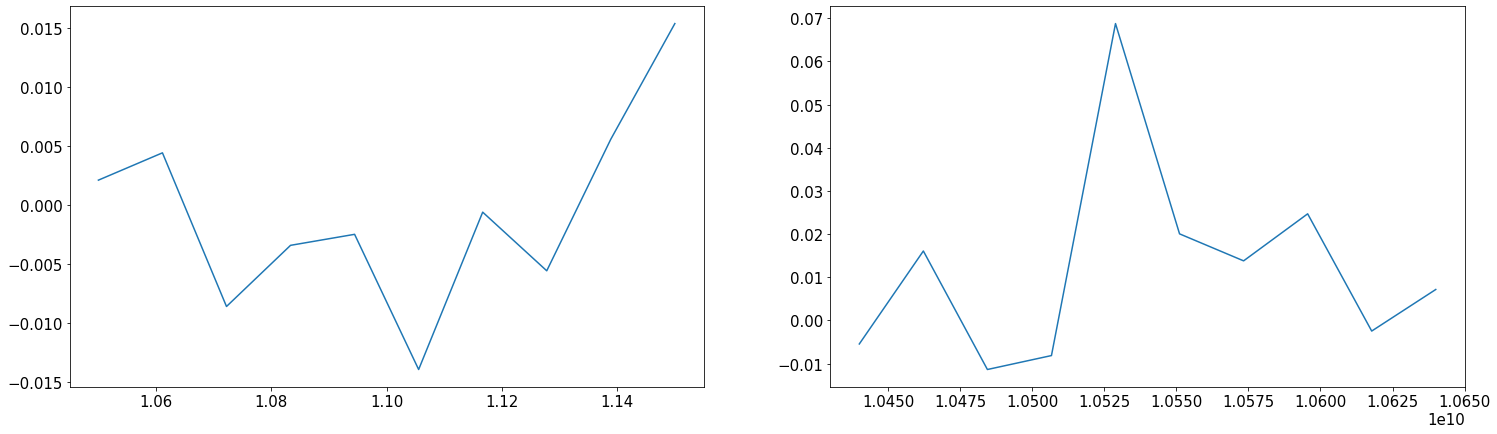

In [438]:
def dbtomag(db):
    return 10 ** (db / 10)

best_gain_index = np.argmax(actual_gain)


bg_dc = best_gain_DC[best_gain_index]
bg_pp = best_gain_pp[best_gain_index]
bg_pf = best_gain_pf[best_gain_index]


avg = 10

font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25, 7))

if bg_dc<7 and bg_pp<10.1:
    
    dc.set_volt(np.round(bg_dc,2))
    anapico.set_freq(1, bg_pf)
    anapico.set_power(1, bg_pp)

    start_time = datetime.now()    
    print('Script started at:', start_time.strftime(r'%Y.%m.%d %H-%M-%S'))

    file = r'DC_bg_sweep_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
    file_name = path +'\\' + file
    
    print('Best gain:', np.round(actual_gain[best_gain_index],2), bg_dc, np.round(bg_pf/1e9, 2), np.round(bg_pp,2))

    # Sweep gain in 3 directions near bg point 

    bg_delta_dc = 0.05 #V
    bg_dc_sweep = np.linspace(bg_dc-bg_delta_dc, bg_dc+bg_delta_dc, 10)

    
    state = dict()
    
    state['bg_dc_sweep'] = bg_dc_sweep 

    DC_bg_sweep_1f_noise_mag = np.ones((len(bg_dc_sweep),avg,vna.get_nop()))*(0)
    DC_bg_sweep_1f_noise_pha = np.ones((len(bg_dc_sweep),avg,vna.get_nop()))*(0)
    
    gain_dc_gb_sweep = np.array([])
    
    for dc_idx_bg in range(len(bg_dc_sweep)):
        new_time = datetime.now()    
        print('Script started at:', new_time.strftime(r'%Y.%m.%d %H-%M-%S'))

        print('New DC set to:', bg_dc_sweep[dc_idx_bg])
        
        vna.set_band(2000)
        vna.set_nop(50)
        
        dc.set_volt(np.round(bg_dc_sweep[dc_idx_bg],2))
        
        anapico.set_off(1)
        mag_no_gain, _ = vna.get_data() # reference mag
        anapico.set_on(1)
        
        mag_gain, _ = vna.get_data() # reference mag
    
        gain_dc_gb_sweep = np.append(gain_dc_gb_sweep, np.mean(mag_gain) - np.mean(mag_no_gain))
        
        vna.set_band(10)
        vna.set_nop(101)

        for i_av in range(avg):
        
            mag, pha = vna.get_data()
            DC_bg_sweep_1f_noise_mag[dc_idx_bg,i_av,:] = fft_A(dbtomag(mag-np.mean(mag)))
            DC_bg_sweep_1f_noise_pha[dc_idx_bg,i_av,:] = fft_A(dbtomag(pha-np.mean(pha)))
            
        state['DC_bg_sweep_1f_noise_mag'] = DC_bg_sweep_1f_noise_mag 
        state['DC_bg_sweep_1f_noise_pha'] = DC_bg_sweep_1f_noise_pha 
        state['gain_dc_gb_sweep'] = gain_dc_gb_sweep 
        savemat(file_name, state)
        
    ax[0].plot(bg_dc_sweep, gain_dc_gb_sweep)
    
    
    bg_delta_pf = 0.1e9
    bg_pf_sweep = np.linspace(bg_pf-bg_delta_pf, bg_pf+bg_delta_pf, 10)

    
    state['bg_pf_sweep'] = bg_pf_sweep  
    
    pf_bg_sweep_1f_noise_mag = np.ones((len(bg_pf_sweep),avg,vna.get_nop()))*(0)
    pf_bg_sweep_1f_noise_pha = np.ones((len(bg_pf_sweep),avg,vna.get_nop()))*(0)
    
    gain_pf_gb_sweep = np.array([])
    
    for pf_idx_bg in range(len(bg_pf_sweep)):
        new_time = datetime.now()    
        print('Script started at:', new_time.strftime(r'%Y.%m.%d %H-%M-%S'))
        print('New pf set to:', bg_pf_sweep[pf_idx_bg])
        
        vna.set_band(2000)
        vna.set_nop(50)
        
        anapico.set_freq(1, bg_pf_sweep[pf_idx_bg])
        
        anapico.set_off(1)
        mag_no_gain, _ = vna.get_data() # reference mag
        anapico.set_on(1)
        
        mag_gain, _ = vna.get_data() # reference mag
    
        gain_pf_gb_sweep = np.append(gain_pf_gb_sweep, np.mean(mag_gain) - np.mean(mag_no_gain))
        
        vna.set_band(10)
        vna.set_nop(101)

        for i_av in range(avg):
        
            mag, pha = vna.get_data()
            pf_bg_sweep_1f_noise_mag[pf_idx_bg,i_av,:] = fft_A(dbtomag(mag-np.mean(mag)))
            pf_bg_sweep_1f_noise_pha[pf_idx_bg,i_av,:] = fft_A(dbtomag(pha-np.mean(pha)))
            
        state['pf_bg_sweep_1f_noise_mag'] = pf_bg_sweep_1f_noise_mag 
        state['pf_bg_sweep_1f_noise_pha'] = pf_bg_sweep_1f_noise_pha 
        state['gain_pf_gb_sweep'] = gain_pf_gb_sweep 
        savemat(file_name, state)
        
    ax[1].plot(bg_pf_sweep, gain_pf_gb_sweep)

In [439]:
dc.set_volt(0)

In [131]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

setup_VNA()

database = create_database()

start_time = datetime.now()     
file = r'gain_database_sweep_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file
state = dict()

print('Script started at:', start_time.strftime(r'%Y.%m.%d %H-%M-%S'))
# looks for regions with best gain 
best_gain_DC, best_gain_pp, best_gain_pf, actual_gain, DC_unit, PP_unit, PF_unit, state = sweep_database(database, file_name = file_name, state=state)

# Sweeps around best gain points to record noise




Script started at: 2025.01.25 20-28-45
2025.01.25 20-32-03.00, 1.07] PF[13.50] = [13.46, 13.50] PP[12.0000] = [9.55, 12.00] --> -19.7536
Duration: 0:03:18.774930. End of step #1 in: 2:15:18 

Range DC[1.15] = [1.07, 1.23] PF[10.42] = [10.38, 10.46] PP[6.3300] = [3.91, 8.80] --> 19.1746332
Range DC[1.15] = [1.07, 1.23] PF[10.46] = [10.42, 10.49] PP[6.3300] = [3.91, 8.80] --> 20.911487
Range DC[1.30] = [1.23, 1.38] PF[9.96] = [9.93, 10.00] PP[3.5000] = [1.05, 5.95] --> 18.503154358
Range DC[1.30] = [1.23, 1.38] PF[10.04] = [10.00, 10.07] PP[3.5000] = [1.05, 5.95] --> 19.60050
Range DC[1.38] = [1.30, 1.45] PF[9.54] = [9.51, 9.58] PP[3.5000] = [1.05, 5.95] --> 18.2074936900
Range DC[1.38] = [1.30, 1.45] PF[9.62] = [9.58, 9.65] PP[3.5000] = [1.05, 5.95] --> 19.904144
Range DC[1.45] = [1.38, 1.52] PF[9.86] = [9.82, 9.90] PP[6.3300] = [3.91, 8.80] --> 20.744914417
Range DC[2.65] = [2.58, 2.73] PF[9.40] = [9.37, 9.44] PP[3.5000] = [1.05, 5.95] --> 18.0873215816
Range DC[2.73] = [2.65, 2.80] PF

________________________________________________________
________________________________________________________
Rougf sweep finished, Fine one started at: 2025-01-26-16-43-26
Number of high-gain points:  51
________________________________________________________
________________________________________________________
New best gain point 0 \ 51
Duration: 0:00:37.530085. End of step #2 in: 5:45:57 20] PP[10.0900] = [8.62, 10.00] --> -7.3979

Range DC[1.06] = [0.68, 1.44] PF[10.64] = [10.13, 11.14] PP[8.6200] = [7.24, 10.00] --> 20.06827
Range DC[1.10] = [0.72, 1.48] PF[10.53] = [10.02, 11.04] PP[7.1400] = [5.74, 8.50] --> 19.514002
Range DC[1.10] = [0.72, 1.48] PF[10.53] = [10.02, 11.04] PP[7.6300] = [6.28, 9.04] --> 22.497
Range DC[1.10] = [0.72, 1.48] PF[10.55] = [10.04, 11.06] PP[7.1400] = [5.74, 8.50] --> 21.467237
Range DC[1.10] = [0.72, 1.48] PF[10.55] = [10.04, 11.06] PP[7.6300] = [6.28, 9.04] --> 20.114
Range DC[1.10] = [0.72, 1.48] PF[10.62] = [10.12, 11.13] PP[7.1400] = [5.

Range DC[1.30] = [0.92, 1.68] PF[10.04] = [9.53, 10.54] PP[3.1000] = [1.72, 4.48] --> 19.315
Range DC[1.30] = [0.92, 1.68] PF[10.04] = [9.53, 10.54] PP[3.5900] = [2.20, 4.96] --> 19.810
Range DC[1.30] = [0.92, 1.68] PF[10.04] = [9.53, 10.54] PP[4.0800] = [2.68, 5.44] --> 20.275
Range DC[1.30] = [0.92, 1.68] PF[10.05] = [9.55, 10.56] PP[3.1000] = [1.72, 4.48] --> 19.236
Range DC[1.30] = [0.92, 1.68] PF[10.05] = [9.55, 10.56] PP[3.5900] = [2.20, 4.96] --> 19.289
Range DC[1.42] = [1.04, 1.80] PF[9.87] = [9.36, 10.38] PP[5.5600] = [4.18, 6.94] --> 20.63787
Range DC[1.42] = [1.04, 1.80] PF[9.87] = [9.36, 10.38] PP[6.0500] = [4.66, 7.42] --> 22.711
Range DC[1.42] = [1.04, 1.80] PF[9.89] = [9.38, 10.40] PP[6.0500] = [4.66, 7.42] --> 21.4163
New best gain point 7 \ 5188] PF[10.05] = [9.55, 10.56] PP[6.5400] = [5.14, 7.90] --> -10.265
Duration: 0:48:38.603311. End of step #2 in: 18 days, 22:43:18 00] = [4.54, 7.30] --> 2.2822

Range DC[1.26] = [0.88, 1.64] PF[10.06] = [9.56, 10.57] PP[4.4500] =

Range DC[1.26] = [0.88, 1.64] PF[10.09] = [9.58, 10.60] PP[4.9500] = [3.58, 6.34] --> 19.2973
Range DC[1.26] = [0.88, 1.64] PF[10.11] = [9.61, 10.62] PP[4.4600] = [3.10, 5.86] --> 19.9915
Range DC[1.26] = [0.88, 1.64] PF[10.11] = [9.61, 10.62] PP[4.9500] = [3.58, 6.34] --> 21.279
Range DC[1.26] = [0.88, 1.64] PF[10.11] = [9.61, 10.62] PP[5.4500] = [4.06, 6.82] --> 19.769
Range DC[1.30] = [0.92, 1.68] PF[9.98] = [9.47, 10.48] PP[3.4800] = [2.08, 4.84] --> 19.68599
Range DC[1.30] = [0.92, 1.68] PF[10.02] = [9.51, 10.52] PP[3.4800] = [2.08, 4.84] --> 19.2333
Range DC[1.30] = [0.92, 1.68] PF[10.02] = [9.51, 10.52] PP[3.9700] = [2.62, 5.38] --> 19.678
Range DC[1.30] = [0.92, 1.68] PF[10.04] = [9.53, 10.54] PP[2.9900] = [1.60, 4.36] --> 19.2008
Range DC[1.30] = [0.92, 1.68] PF[10.04] = [9.53, 10.54] PP[3.4800] = [2.08, 4.84] --> 19.679
Range DC[1.30] = [0.92, 1.68] PF[10.04] = [9.53, 10.54] PP[3.9700] = [2.62, 5.38] --> 20.220
Range DC[1.30] = [0.92, 1.68] PF[10.05] = [9.55, 10.56] PP[2.9900

Range DC[1.40] = [1.02, 1.78] PF[9.55] = [9.04, 10.06] PP[3.6300] = [2.26, 5.02] --> 19.298
Range DC[1.40] = [1.02, 1.78] PF[9.57] = [9.06, 10.07] PP[3.6300] = [2.26, 5.02] --> 20.2495
New best gain point 19 \ 518] PF[9.64] = [9.14, 10.15] PP[5.1100] = [3.70, 6.46] --> 5.782150
Duration: 2:11:06.391629. End of step #2 in: 51 days, 1:47:06 00] = [4.06, 6.82] --> 10.210

Range DC[1.36] = [0.98, 1.74] PF[9.57] = [9.06, 10.07] PP[2.9900] = [1.60, 4.36] --> 19.1438
Range DC[1.36] = [0.98, 1.74] PF[9.61] = [9.10, 10.11] PP[3.4800] = [2.08, 4.84] --> 19.0830
Range DC[1.40] = [1.02, 1.78] PF[9.55] = [9.04, 10.06] PP[2.9900] = [1.60, 4.36] --> 19.5215
Range DC[1.40] = [1.02, 1.78] PF[9.55] = [9.04, 10.06] PP[3.4800] = [2.08, 4.84] --> 19.484
Range DC[1.40] = [1.02, 1.78] PF[9.57] = [9.06, 10.07] PP[2.9900] = [1.60, 4.36] --> 19.6722
Range DC[1.40] = [1.02, 1.78] PF[9.57] = [9.06, 10.07] PP[3.4800] = [2.08, 4.84] --> 20.347
New best gain point 20 \ 518] PF[9.64] = [9.14, 10.15] PP[5.4500] = [4.0

Range DC[2.76] = [2.38, 3.14] PF[9.77] = [9.26, 10.28] PP[3.1000] = [1.72, 4.48] --> 19.3839
Range DC[2.76] = [2.38, 3.14] PF[9.77] = [9.26, 10.28] PP[3.5900] = [2.20, 4.96] --> 19.501
Range DC[2.76] = [2.38, 3.14] PF[9.77] = [9.26, 10.28] PP[4.0800] = [2.68, 5.44] --> 19.357
Range DC[2.76] = [2.38, 3.14] PF[9.79] = [9.28, 10.29] PP[3.1000] = [1.72, 4.48] --> 19.363
Range DC[2.76] = [2.38, 3.14] PF[9.79] = [9.28, 10.29] PP[3.5900] = [2.20, 4.96] --> 19.997
Range DC[2.76] = [2.38, 3.14] PF[9.81] = [9.30, 10.31] PP[4.0800] = [2.68, 5.44] --> 19.014
Range DC[2.80] = [2.42, 3.18] PF[9.84] = [9.34, 10.35] PP[3.1000] = [1.72, 4.48] --> 19.038
Range DC[2.80] = [2.42, 3.18] PF[9.84] = [9.34, 10.35] PP[3.5900] = [2.20, 4.96] --> 19.676
Range DC[2.80] = [2.42, 3.18] PF[9.84] = [9.34, 10.35] PP[4.0800] = [2.68, 5.44] --> 19.224
New best gain point 29 \ 518] PF[9.92] = [9.41, 10.42] PP[6.5400] = [5.14, 7.90] --> 10.541
Duration: 3:19:49.061446. End of step #2 in: 77 days, 20:17:09 00] = [4.54, 7.3

Range DC[2.80] = [2.42, 3.18] PF[10.13] = [9.62, 10.63] PP[3.5900] = [2.20, 4.96] --> 19.556
Range DC[2.80] = [2.42, 3.18] PF[10.13] = [9.62, 10.63] PP[4.0800] = [2.68, 5.44] --> 20.197
Range DC[2.80] = [2.42, 3.18] PF[10.13] = [9.62, 10.63] PP[4.5700] = [3.22, 5.98] --> 20.712
Range DC[2.80] = [2.42, 3.18] PF[10.15] = [9.64, 10.65] PP[3.5900] = [2.20, 4.96] --> 19.956
Range DC[2.80] = [2.42, 3.18] PF[10.15] = [9.64, 10.65] PP[4.0800] = [2.68, 5.44] --> 20.213
Range DC[2.80] = [2.42, 3.18] PF[10.15] = [9.64, 10.65] PP[4.5700] = [3.22, 5.98] --> 20.661
Range DC[2.80] = [2.42, 3.18] PF[10.15] = [9.64, 10.65] PP[5.0600] = [3.70, 6.46] --> 19.662
Range DC[2.84] = [2.46, 3.22] PF[10.15] = [9.64, 10.65] PP[5.0600] = [3.70, 6.46] --> 19.264
New best gain point 37 \ 518] PF[10.15] = [9.64, 10.65] PP[6.5400] = [5.14, 7.90] --> 10.377
Duration: 4:15:05.914365. End of step #2 in: 99 days, 9:01:45 500] = [4.06, 6.82] --> -13.970

Range DC[2.76] = [2.38, 3.14] PF[10.05] = [9.55, 10.56] PP[5.4500] =

Range DC[2.80] = [2.42, 3.18] PF[10.15] = [9.64, 10.65] PP[4.8100] = [3.40, 6.16] --> 20.257
Range DC[2.84] = [2.46, 3.22] PF[10.15] = [9.64, 10.65] PP[4.8100] = [3.40, 6.16] --> 19.3386
Range DC[2.84] = [2.46, 3.22] PF[10.16] = [9.66, 10.67] PP[5.7900] = [4.42, 7.18] --> 19.205
Range DC[2.84] = [2.46, 3.22] PF[10.18] = [9.68, 10.69] PP[4.3200] = [2.92, 5.68] --> 19.295
Range DC[2.84] = [2.46, 3.22] PF[10.18] = [9.68, 10.69] PP[4.8100] = [3.40, 6.16] --> 20.355
Range DC[2.84] = [2.46, 3.22] PF[10.18] = [9.68, 10.69] PP[5.3000] = [3.94, 6.70] --> 20.906
Range DC[2.84] = [2.46, 3.22] PF[10.18] = [9.68, 10.69] PP[5.7900] = [4.42, 7.18] --> 19.710
Range DC[2.88] = [2.50, 3.26] PF[10.20] = [9.69, 10.71] PP[6.2800] = [4.90, 7.66] --> 20.442
Range DC[2.88] = [2.50, 3.26] PF[10.22] = [9.71, 10.73] PP[5.3000] = [3.94, 6.70] --> 19.312
Range DC[2.88] = [2.50, 3.26] PF[10.22] = [9.71, 10.73] PP[5.7900] = [4.42, 7.18] --> 20.203
Range DC[2.88] = [2.50, 3.26] PF[10.22] = [9.71, 10.73] PP[6.2800] = 

Range DC[3.00] = [2.62, 3.38] PF[10.50] = [10.00, 11.01] PP[8.1200] = [6.76, 9.52] --> 20.070777
Range DC[3.00] = [2.62, 3.38] PF[10.52] = [10.02, 11.03] PP[7.6300] = [6.28, 9.04] --> 20.809781
Range DC[3.00] = [2.62, 3.38] PF[10.52] = [10.02, 11.03] PP[8.1200] = [6.76, 9.52] --> 22.786
Range DC[3.00] = [2.62, 3.38] PF[10.54] = [10.03, 11.05] PP[7.1400] = [5.74, 8.50] --> 19.062750
Range DC[3.00] = [2.62, 3.38] PF[10.54] = [10.03, 11.05] PP[7.6300] = [6.28, 9.04] --> 21.977
Range DC[3.00] = [2.62, 3.38] PF[10.54] = [10.03, 11.05] PP[8.1200] = [6.76, 9.52] --> 20.513
Range DC[3.00] = [2.62, 3.38] PF[10.56] = [10.05, 11.06] PP[7.1400] = [5.74, 8.50] --> 19.621692
New best gain point 45 \ 518] PF[10.56] = [10.05, 11.06] PP[10.0900] = [8.62, 10.00] --> -8.1929
Duration: 5:09:59.273083. End of step #2 in: 120 days, 18:20:39 00] = [7.66, 10.00] --> -21.440

Range DC[2.92] = [2.54, 3.30] PF[10.48] = [9.98, 10.99] PP[6.1000] = [4.72, 7.48] --> 19.027515
Range DC[2.92] = [2.54, 3.30] PF[10.50] 

Range DC[3.00] = [2.62, 3.38] PF[10.60] = [10.09, 11.10] PP[8.1200] = [6.76, 9.52] --> 20.038284
Range DC[3.00] = [2.62, 3.38] PF[10.61] = [10.11, 11.12] PP[7.6300] = [6.28, 9.04] --> 19.846952
Range DC[3.00] = [2.62, 3.38] PF[10.61] = [10.11, 11.12] PP[8.1200] = [6.76, 9.52] --> 21.273
Range DC[3.00] = [2.62, 3.38] PF[10.63] = [10.13, 11.14] PP[7.6300] = [6.28, 9.04] --> 19.571077
Range DC[3.00] = [2.62, 3.38] PF[10.63] = [10.13, 11.14] PP[8.1200] = [6.76, 9.52] --> 19.594
Range DC[3.04] = [2.66, 3.42] PF[10.63] = [10.13, 11.14] PP[8.6200] = [7.24, 10.00] --> 19.04348
New best gain point 47 \ 518] PF[10.65] = [10.14, 11.16] PP[10.0900] = [8.62, 10.00] --> -11.462
Duration: 5:23:45.540372. End of step #2 in: 126 days, 3:03:45 0900] = [8.62, 10.00] --> -21.197

Range DC[2.92] = [2.54, 3.30] PF[10.51] = [10.01, 11.02] PP[5.6600] = [4.30, 7.06] --> 19.996903
Range DC[2.96] = [2.58, 3.34] PF[10.51] = [10.01, 11.02] PP[6.1600] = [4.78, 7.54] --> 19.700116
Range DC[2.96] = [2.58, 3.34] PF[10

C:\Users\Demag\AppData\Local\Temp\ipykernel_4444\1294214475.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


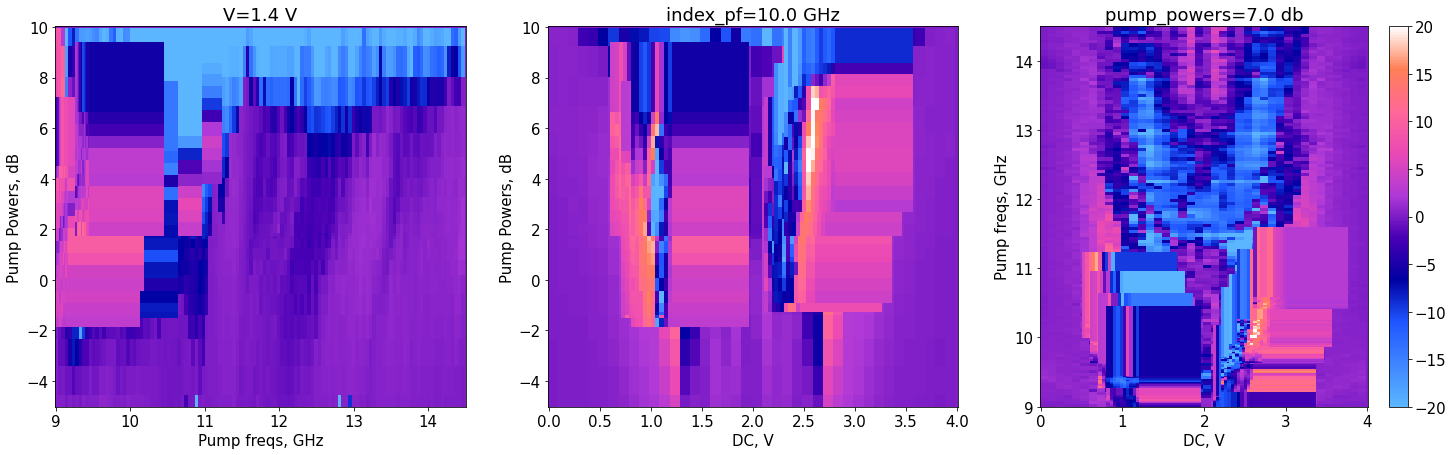

In [299]:
gain_search_treshhold_final = 20

best_gain_DC_final = np.array([])
best_gain_pp_final = np.array([])
best_gain_pf_final = np.array([])
actual_gain_final = np.array([])

print("________________________________________________________")
print("________________________________________________________")

mid_time = datetime.now()     
print('Rougf sweep finished, Fine one started at: '+ mid_time.strftime(r'%Y-%m-%d-%H-%M-%S'))
print('Number of high-gain points: ', len(actual_gain))


print("________________________________________________________")
print("________________________________________________________")


ratio = 5 # points per sell to be added

for gain_i in range(len(actual_gain)):
    print("New best gain point", gain_i, "\\", len(actual_gain))
    
    New_best_DC = 0
    New_best_PP = 0
    New_best_PF = 0
    New_best_gain = 0
    # create new arrays near each gain point
    
    delta_dc = DC_unit*2
    steps_dc = ratio 
    rough_dc = np.linspace(best_gain_DC[gain_i]-delta_dc, best_gain_DC[gain_i]+delta_dc, steps_dc*2+1)
    
    delta_pp = PP_unit*2
    steps_pp = ratio
    rough_pp = np.linspace(best_gain_pp[gain_i]-delta_pp, best_gain_pp[gain_i]+delta_pp, steps_pp*2+1)
    
    delta_pf = PF_unit*2 
    steps_pf = ratio
    rough_pf = np.linspace(best_gain_pf[gain_i]-delta_pf, best_gain_pf[gain_i]+delta_pf, steps_pf*2+1)
    
    for i_dc in range(len(rough_dc)):
        dc.set_volt(rough_dc[i_dc])
        time.sleep(5) 

        anapico.set_off(1)

        mag_no_gain, pha_no_gain = vna.get_data() # reference mag
        anapico.set_on(1)


        for i_pf in range(len(rough_pf)):
            anapico.set_freq(1, rough_pf[i_pf])
            for i_pp in range(len(rough_pp)):
                anapico.set_power(1, rough_pp[i_pp])

                database, sell_gain  = fill_sell(database = database, 
                                     mag_no_gain = mag_no_gain, treshhold_gain = 19, 
                                     volts_curr = rough_dc[i_dc],
                                     pump_freqs_curr = rough_pf[i_pf], 
                                     pump_powers_curr = rough_pp[i_pp],
                                     delta_dc = int(len(database['volts'])/len(rough_dc))+1, 
                                     delta_pf = int(len(database['pump_freqs'])/len(rough_pf))+1, 
                                     delta_pp = int(len(database['pump_powers'])/len(rough_pp))+1)

                if sell_gain>gain_search_treshhold_final:
                    
                    if New_best_gain<sell_gain:
                        New_best_DC = rough_dc[i_dc]
                        New_best_PP = rough_pp[i_pp]
                        New_best_PF = rough_pf[i_pf]
                        New_best_gain = sell_gain
        if i_dc == 0: 

            duration_end = datetime.now()
            period = (duration_end-mid_time).seconds

            print('Duration: {}. End of step #2 in: {} \n'.format(duration_end - mid_time, 
                                            timedelta(seconds=period*len(rough_dc)*len(actual_gain))))

    best_gain_DC_final = np.append(best_gain_DC_final, New_best_DC)
    best_gain_pp_final = np.append(best_gain_pp_final, New_best_PP)
    best_gain_pf_final = np.append(best_gain_pf_final, New_best_PF)
    actual_gain_final = np.append(actual_gain_final, New_best_gain)

    state['best_gain_DC_final'] = best_gain_DC_final
    state['best_gain_pp_final'] = best_gain_pp_final
    state['best_gain_DC_final'] = best_gain_pf_final
    state['best_gain_final'] = actual_gain_final

    savemat(file_name, state)

        

end_time = datetime.now()     
print(end_time.strftime(r'%Y.%m.%d %H-%M-%S'))

anapico.set_off(1)

print('Subtotal run time: {}'.format(timedelta(seconds=(end_time-mid_time).seconds)))
    
print('Total run time: {}'.format(timedelta(seconds=(end_time-start_time).seconds)))
plot_database(database)


In [302]:
actual_gain_final

array([22.49692, 20.20625, 21.99987, 21.68339, 22.70255, 22.63052,
       22.71103, 20.98534, 21.51292, 21.64833, 21.91519, 21.77223,
       21.76366, 21.79068, 20.35677,  0.     , 20.14452, 20.2937 ,
       20.24874, 20.34711, 20.28306, 20.40216, 21.92322,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     , 20.59212,
       20.42821,  0.     ,  0.     ,  0.     , 20.82244, 20.82137,
       20.71187, 20.90658, 20.92302, 20.8661 , 20.90563, 20.73737,
       20.54872, 20.44347, 22.78584, 22.81334, 22.82302, 22.85765,
       21.39714, 21.10741,  0.     ])

In [39]:
# at this point we get set of best-gain points. 
# let's measure noise + variance near each point



(array([-14.67956955, -14.79396446, -14.67562261, -14.6162314 ,
        -14.54956549, -14.73300586, -14.6702168 , -14.86851152,
        -14.69258992, -14.73149478]),
 array([1.88842736, 1.88645506, 1.90095165, 1.89342193, 1.89888587,
        1.89347471, 1.90219629, 1.8996951 , 1.90400462, 1.88873993]))

In [309]:
file = r'TWPA_4_gain_database_sweep_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.npy'
file_name = path +'\\' + file

np.save(file_name, database)

In [330]:
loaded_table = np.load(file_name, allow_pickle=True).item()
loaded_table

{'pump_powers': array([-5.  , -4.94, -4.88, -4.82, -4.76, -4.7 , -4.64, -4.58, -4.52,
        -4.46, -4.4 , -4.34, -4.28, -4.22, -4.16, -4.1 , -4.04, -3.98,
        -3.92, -3.86, -3.8 , -3.74, -3.68, -3.62, -3.56, -3.5 , -3.44,
        -3.38, -3.32, -3.26, -3.2 , -3.14, -3.08, -3.02, -2.96, -2.9 ,
        -2.84, -2.78, -2.72, -2.66, -2.6 , -2.54, -2.48, -2.42, -2.36,
        -2.3 , -2.24, -2.18, -2.12, -2.06, -2.  , -1.94, -1.88, -1.82,
        -1.76, -1.7 , -1.64, -1.58, -1.52, -1.46, -1.4 , -1.34, -1.28,
        -1.22, -1.16, -1.1 , -1.04, -0.98, -0.92, -0.86, -0.8 , -0.74,
        -0.68, -0.62, -0.56, -0.5 , -0.44, -0.38, -0.32, -0.26, -0.2 ,
        -0.14, -0.08, -0.02,  0.04,  0.1 ,  0.16,  0.22,  0.28,  0.34,
         0.4 ,  0.46,  0.52,  0.58,  0.64,  0.7 ,  0.76,  0.82,  0.88,
         0.94,  1.  ,  1.06,  1.12,  1.18,  1.24,  1.3 ,  1.36,  1.42,
         1.48,  1.54,  1.6 ,  1.66,  1.72,  1.78,  1.84,  1.9 ,  1.96,
         2.02,  2.08,  2.14,  2.2 ,  2.26,  2.32,  2.38,  2.44

In [325]:
loaded_table['data'].shape

(201, 1001, 251)

In [311]:
plot_database(loaded_table, desired_DC=1.3, desired_pf=10.5e9, desired_pp=7)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

2025.01.23 23-01-02
Duration: 0:10:11.701884. End of script in: 599 days, 1:20:211,15.0] --> -16.571746871852
Range DC[0.9]=[0.8,1.0] PF[11.0]=[10.966,11.034] PP[10.0]=[7.71,12.29] --> 13.06402951011
Range DC[0.9]=[0.8,1.0] PF[11.03333]=[10.999,11.067] PP[10.0]=[7.71,12.29] --> 15.801836
Range DC[1.0]=[0.9,1.1] PF[10.56667]=[10.533,10.601] PP[7.5]=[5.21,9.79] --> 14.936352925
Range DC[1.0]=[0.9,1.1] PF[10.6]=[10.566,10.634] PP[7.5]=[5.21,9.79] --> 13.6977568561413
Range DC[1.0]=[0.9,1.1] PF[10.9]=[10.866,10.934] PP[7.5]=[5.21,9.79] --> 13.2443861425341
Range DC[1.0]=[0.9,1.1] PF[10.93333]=[10.899,10.967] PP[7.5]=[5.21,9.79] --> 14.00886368
Range DC[1.1]=[1.0,1.2] PF[9.6]=[9.566,9.634] PP[5.0]=[2.71,7.29] --> 13.6734346511856338
Range DC[1.1]=[1.0,1.2] PF[10.43333]=[10.399,10.467] PP[7.5]=[5.21,9.79] --> 13.705247415
Range DC[1.1]=[1.0,1.2] PF[10.63333]=[10.599,10.667] PP[5.0]=[2.71,7.29] --> 13.539120332
Range DC[1.2]=[1.1,1.3] PF[9.23333]=[9.199,9.267] PP[5.0]=[2.71,7.29] --> 13.10109

Range DC[2.7]=[2.6,2.8] PF[10.23333]=[10.199,10.267] PP[5.0]=[2.71,7.29] --> 16.06221592
Range DC[2.7]=[2.6,2.8] PF[10.23333]=[10.199,10.267] PP[7.5]=[5.21,9.79] --> 17.17483
Range DC[2.7]=[2.6,2.8] PF[10.26667]=[10.233,10.301] PP[7.5]=[5.21,9.79] --> 15.815852556
Range DC[2.7]=[2.6,2.8] PF[10.3]=[10.266,10.334] PP[7.5]=[5.21,9.79] --> 16.3554341699192
Range DC[2.7]=[2.6,2.8] PF[10.33333]=[10.299,10.367] PP[7.5]=[5.21,9.79] --> 15.68914376
Range DC[2.7]=[2.6,2.8] PF[10.36667]=[10.333,10.401] PP[7.5]=[5.21,9.79] --> 15.336084676
Range DC[2.8]=[2.7,2.9] PF[9.0]=[9.0,9.034] PP[12.5]=[10.21,14.79] --> 14.481286439374651
Range DC[2.8]=[2.7,2.9] PF[9.06667]=[9.033,9.101] PP[10.0]=[7.71,12.29] --> 19.207486
Range DC[2.8]=[2.7,2.9] PF[9.1]=[9.066,9.134] PP[7.5]=[5.21,9.79] --> 14.81392925868
Range DC[2.8]=[2.7,2.9] PF[9.13333]=[9.099,9.167] PP[7.5]=[5.21,9.79] --> 15.41934594
Range DC[2.8]=[2.7,2.9] PF[9.16667]=[9.133,9.201] PP[7.5]=[5.21,9.79] --> 16.702785378
Range DC[2.8]=[2.7,2.9] PF[9.2]=

C:\Users\Demag\AppData\Local\Temp\ipykernel_42212\2912551570.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


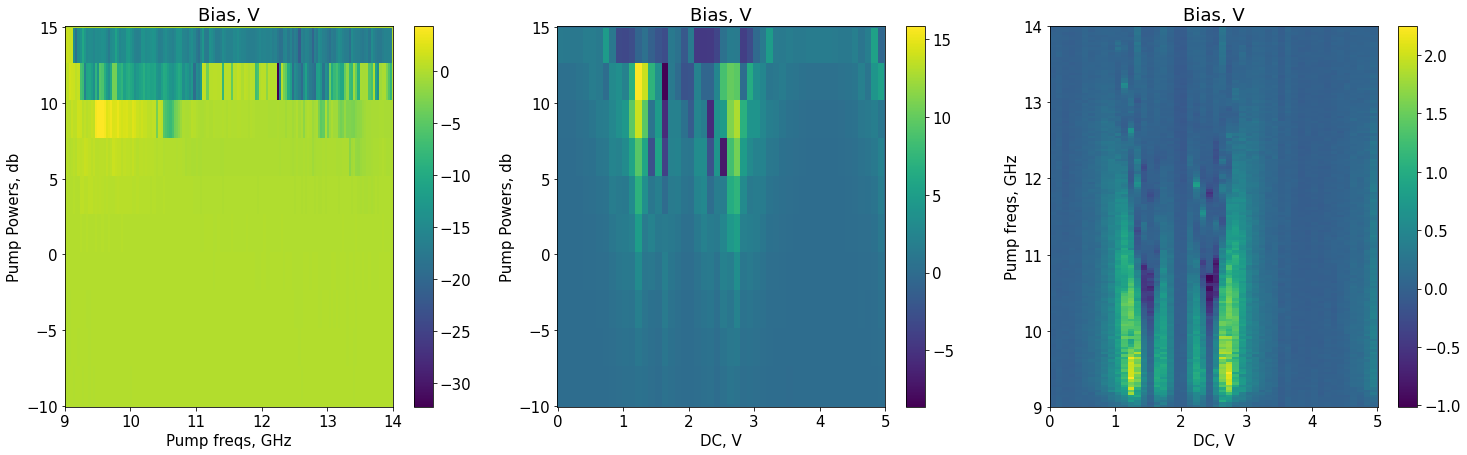

In [94]:
# Create database for just one point in VNA 
font = {'size'   : 15}
matplotlib.rc('font', **font)

database = create_database()
# plot_database(database)

pump_freqs = database['pump_freqs']
pump_powers = database['pump_powers']
volts = database['volts']

rough_dc = np.linspace(min(volts), max(volts), 51)
rough_pp = np.linspace(min(pump_powers), max(pump_powers), 11)
rough_pf = np.linspace(min(pump_freqs), max(pump_freqs), 151)

start_time = datetime.now()     
file = r'rough_gain_database_sweep_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

state = dict()


print(start_time.strftime(r'%Y.%m.%d %H-%M-%S'))

# best gain points saved for better consideration

best_gain_DC = np.array([])
best_gain_pp = np.array([])
best_gain_pf = np.array([])
actual_gain = np.array([])

gain_search_treshhold = 19

for i_dc in range(len(rough_dc)):
    dc.set_volt(rough_dc[i_dc])
    time.sleep(5)
        
    anapico.set_off(1)
    mag_no_gain, pha_no_gain = vna.get_data() # reference mag
    anapico.set_on(1)
    
    for i_pf in range(len(rough_pf)):
        anapico.set_freq(1, rough_pf[i_pf])
        for i_pp in range(len(rough_pp)):
            anapico.set_power(1, rough_pp[i_pp])
        
            
            database = fill_sell(database = database, 
                                 mag_no_gain = mag_no_gain, 
                                 volts_curr = rough_dc[i_dc],
                                 pump_freqs_curr = rough_pf[i_pf], 
                                 pump_powers_curr = rough_pp[i_pp],
                                 delta_dc = int(len(volts)/len(rough_dc))+1, 
                                 delta_pf = int(len(pump_freqs)/len(rough_pf))+1, 
                                 delta_pp = int(len(pump_powers)/len(rough_pp))+1)
            
            if database['data']>gain_search_treshhold:
            
                best_gain_DC = np.append(best_gain_DC, rough_dc[i_dc])
                best_gain_pp = np.append(best_gain_pp, rough_pp[i_pp])
                best_gain_pf = np.append(best_gain_pf, rough_pf[i_pf])
                actual_gain = np.append(actual_gain, database['data'])
                
                state['best_gain_DC'] = best_gain_DC 
                state['best_gain_pp'] = best_gain_pp 
                state['best_gain_DC'] = best_gain_pf 
                state['best_gain'] = actual_gain 
                
                savemat(file_name, state)

    if i_dc == 0: 
        
        duration_end = datetime.now()
        period = (duration_end-start_time).seconds
        
        print('Duration: {}. End of script in: {}'.format(duration_end - start_time, 
                                        timedelta(seconds=period*len(rough_dc)*len(rough_pf)*len(rough_pp))))


end_time = datetime.now()     
print(end_time.strftime(r'%Y.%m.%d %H-%M-%S'))

anapico.set_off(1)
anapico.set_power(1, -100)

print('Total run time: {}'.format(timedelta(seconds=(end_time-start_time).seconds)))
plot_database(database)

In [ ]:
# finer database

dc_bin_size = len(rough_dc)
pp_bin_size = len(rough_pp)
pf_bin_size = len(rough_pf)

while dc_bin_size>1 or pp_bin_size>1 or pf_bin_size>1: 
    
    dc_bin_size = int(len(volts)*0.5)
    pp_bin_size = int(len(pump_powers)*0.5)
    pf_bin_size = int(len(pump_freqs)*0.5)
    
    
    finer_dc = np.linspace(min(volts), max(volts), dc_bin_size)
    finer_pp = np.linspace(min(pump_powers), max(pump_powers), 11)
    finer_pf = np.linspace(min(pump_freqs), max(pump_freqs), 51)

C:\Users\Demag\AppData\Local\Temp\ipykernel_42212\2912551570.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


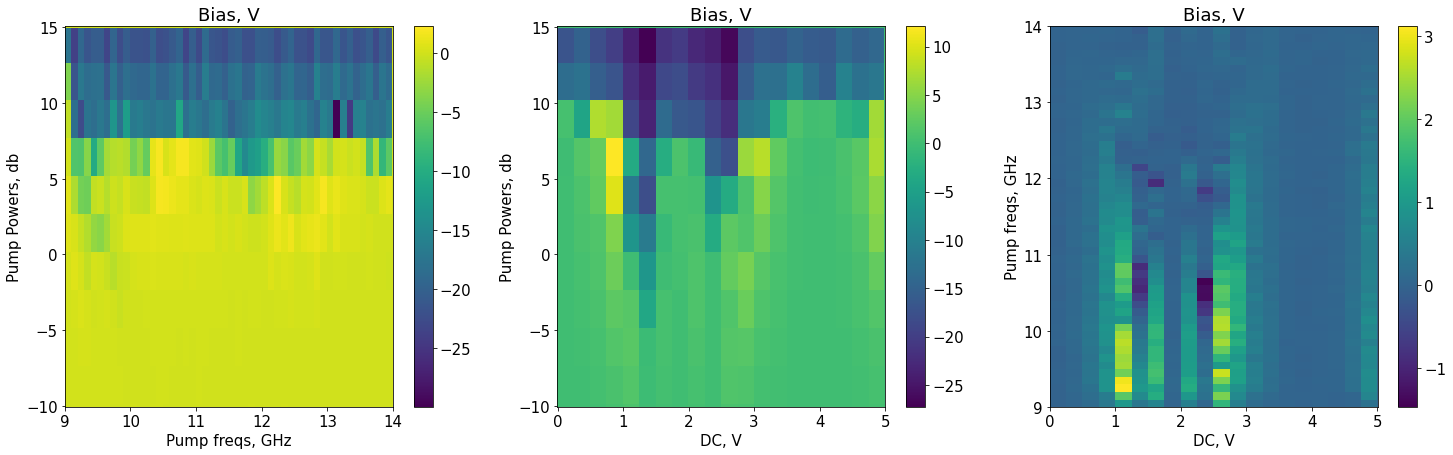

In [93]:
plot_database(database, index_dc=200, index_pf=2000, index_pp=9)

In [ ]:
# Saving failed for some reason
Mayby becouse the size of matrix is too large
So better do not restart yet

In [22]:
anapico.set_off(1)

NameError: name 'anapico' is not defined

# NOISE around best gain point

In [426]:
# best gain point

best_gain_index = 10 #np.argmax(actual_gain_final)

bg_dc = 2.62
bg_pp = 7
bg_pf = 10.1e9

dc.set_volt(np.round(bg_dc,2))
anapico.set_freq(1, bg_pf)
anapico.set_power(1, bg_pp)

print(bg_dc, np.round(bg_pf/1e9, 2), np.round(bg_pp,2))

# Sweep gain in 3 directions near bg point 

bg_delta_dc = 0.05
bg_dc_sweep = np.linspace(2.5, 3, 50)
bg_dc_gain_sweep = np.array([])

bg_delta_pf = 0.5e9
bg_pf_sweep = np.linspace(9.6e9, 10.6e9, 50)
bg_pf_gain_sweep = np.array([])

vna.set_nop(20)

for i_dc in range(len(bg_dc_sweep)):
    dc.set_volt(bg_dc_sweep[i_dc])
    time.sleep(5) 
    
    anapico.set_off(1)
    mag_no_gain_bg, _ = vna.get_data() # reference mag
    anapico.set_on(1)
    for i_pf in range(len(bg_pf_sweep)):

        anapico.set_freq(1, bg_pf_sweep[i_pf])


        mag_with_gain_bg, _ = vna.get_data() # reference mag

        gain_dc_bg = np.mean(mag_with_gain_bg) - np.mean(mag_no_gain_bg)
        bg_dc_gain_sweep = np.append(bg_dc_gain_sweep, gain_dc_bg)

        if gain_dc_bg>16: print(np.round(bg_pf_sweep[i_pf]/1e9, 3), np.round(bg_dc_sweep[i_dc], 3), gain_dc_bg)
        else: print(np.round(bg_pf_sweep[i_pf]/1e9, 3), np.round(bg_dc_sweep[i_dc], 3), gain_dc_bg, end  = '\r')


2.62 10.1 7


KeyboardInterrupt: 

In [416]:
plot_database(database, desired_DC=2.64, desired_pf=10.1e9, desired_pp=7)

In [385]:
dc.set_volt(0)
anapico.set_off(1)

In [365]:
anapico.get_status(1)

1.0

In [380]:
anapico.get_power(1)

5.300362

In [381]:
dc.get_volt()

2.84

# Gain sweep in all directions

Range DC[1.3] PF[9.16667] PP[7.5] --> 20.2568

Range DC[1.3] PF[10.2]    PP[7.5]  --> 18.0159

Range DC[1.3] PF[10.4]    PP[7.5]  --> 20.159

Range DC[1.3] PF[10.4333] PP[7.5]  --> 21.96882

Range DC[1.4] PF[10.0666] PP[7.5]  --> 18.35709

Range DC[1.4] PF[10.13]   PP[7.5]  --> 23.05722

Range DC[1.4] PF[10.1667] PP[7.5]  --> 19.65

Range DC[1.4] PF[10.2]    PP[7.5]  --> 20.03235

Range DC[1.6] PF[9.533]   PP[2.5]  --> 20.3477

Range DC[2.7] PF[10.133]  PP[7.5]  --> 20.83321

Range DC[2.8] PF[9.06667] PP[10.0] --> 19.207486

Range DC[2.8] PF[10.433]  PP[7.5]  --> 22.29429

Range DC[2.8] PF[10.5]    PP[7.5]  --> 21.06208

Range DC[2.9] PF[10.667]  PP[7.5]  --> 18.1257

In [387]:
# impedance matching point 1st tone
%matplotlib qt

In [388]:
from IPython.display import display, clear_output
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25,13))

volts = np.linspace(2.3, 2.7, 21)
vna.set_band(100)
vna.set_nop(1001)
vna.set_lin()
vna.set_freq_start_stop(4e9, 8.5e9, vna.get_nop())

freqs = vna.get_freq()

state = dict()
state['freqs'] = freqs
state['volts'] = volts
# state['vna'] = vna.dump
state['DC_dev'] = dc.dump
# anapico.set_off(1)
# state['anapico'] = anapico.dump()
state['temp'] = 35


mag_1t = np.ones((len(volts),len(freqs)))*(-40)
pha_1t = np.ones((len(volts),len(freqs)))*(0)

state['mag'] = mag_1t
state['pha'] = pha_1t

start_time = datetime.now()
file = r'1st_tone_imp_m_2_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()     
dc.set_volt(volts[0])
dc.set_on()
time.sleep(5)

for i in range(len(volts)):
    
    curr_time = datetime.now()
    print('New round {}/{} ({} V) started at {}'.format(i, len(volts), volts[i], curr_time.strftime(r'%H:%M:%S')))
                      
    mag_1t[i], pha_1t[i] = vna.get_data()
    
    state['mag'] = mag_1t
    state['pha'] = pha_1t
    
    savemat(file_name, state)
    ax[0].cla()
    c = ax[0].pcolor(volts, freqs/1e9,  np.transpose(mag_1t), cmap='viridis')
    ax[0].set_xlabel(r'Bias, V')
    ax[0].set_ylabel(r'Probe frequency, GHz')
    
    ax[1].cla()
    c1 = ax[1].pcolor(volts, freqs/1e9,  np.transpose(pha_1t), cmap='viridis')
    ax[1].set_xlabel(r'Bias, V')
    ax[1].set_ylabel(r'Probe frequency, GHz')
    
    plt.savefig(path +'\\' + '1st_tone_imp_m_2_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.png', dpi=150)
    

    
    if i == 0: 
        ax[0].set_title(r'$|S_{21}|$')
        ax[1].set_title(r'$\angle S_{21} $')

        duration_end = datetime.now()
        period = (duration_end-start_time).seconds
        
        fig.colorbar(c, ax=ax[0])
        fig.colorbar(c1, ax=ax[1])
        
        print('Duration: {}. End of script in: {}'.format(duration_end - start_time, 
                                        timedelta(seconds=period*len(volts))))
    
    display(fig)
    clear_output(wait = True)
    
    if i<len(volts)-1:
        dc.set_volt(np.round(volts[i+1], 5)) 
        plt.pause(10)


dc.set_volt(0)   
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

KeyboardInterrupt: 

In [ ]:
imp_matching_dC = 1.4 # needs to be more presize

In [ ]:
# Half flux point 

In [14]:
from IPython.display import display, clear_output
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25,13))

volts = np.linspace(1.81, 2.21, 51)
vna.set_band(100)
vna.set_nop(1001)
vna.set_lin()
vna.set_freq_start_stop(4e9, 8.5e9, vna.get_nop())

freqs = vna.get_freq()

state = dict()
state['freqs'] = freqs
state['volts'] = volts
# state['vna'] = vna.dump
state['DC_dev'] = dc.dump
# anapico.set_off(1)
# state['anapico'] = anapico.dump()
state['temp'] = 35


mag_1t = np.ones((len(volts),len(freqs)))*(-40)
pha_1t = np.ones((len(volts),len(freqs)))*(0)

state['mag'] = mag_1t
state['pha'] = pha_1t

start_time = datetime.now()
file = r'1st_tone_half_flux_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()     
dc.set_volt(volts[0])
dc.set_on()
time.sleep(5)

for i in range(len(volts)):
    
    curr_time = datetime.now()
    print('New round {}/{} ({} V) started at {}'.format(i, len(volts), volts[i], curr_time.strftime(r'%H:%M:%S')))
                      
    mag_1t[i], pha_1t[i] = vna.get_data()
    
    state['mag'] = mag_1t
    state['pha'] = pha_1t
    
    savemat(file_name, state)
    ax[0].cla()
    c = ax[0].pcolor(volts, freqs/1e9,  np.transpose(mag_1t), cmap='viridis')
    ax[0].set_xlabel(r'Bias, V')
    ax[0].set_ylabel(r'Probe frequency, GHz')
    
    ax[1].cla()
    c1 = ax[1].pcolor(volts, freqs/1e9,  np.transpose(pha_1t), cmap='viridis')
    ax[1].set_xlabel(r'Bias, V')
    ax[1].set_ylabel(r'Probe frequency, GHz')
    
    plt.savefig(path +'\\' + '1st_tone_half_flux_'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.png', dpi=150)
    

    
    if i == 0: 
        ax[0].set_title(r'$|S_{21}|$')
        ax[1].set_title(r'$\angle S_{21} $')

        duration_end = datetime.now()
        period = (duration_end-start_time).seconds
        
        fig.colorbar(c, ax=ax[0])
        fig.colorbar(c1, ax=ax[1])
        
        print('Duration: {}. End of script in: {}'.format(duration_end - start_time, 
                                        timedelta(seconds=period*len(volts))))
    
    display(fig)
    clear_output(wait = True)
    
    if i<len(volts)-1:
        dc.set_volt(np.round(volts[i+1], 5)) 
        plt.pause(10)


dc.set_volt(0)   
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:18:51.366038


In [ ]:
half_flux_dC = 1.4 # needs to be more presize